# **Detailed Analysis**

( The description of figure will change- it is just an sample to mention the concepts)

- Best Configuration
- Best Configuration: 30 years, batch size 32, epochs 80
- MAE: 3.2587


- Training Loss: 2.3098
- Validation Loss: 34.2010

**Observations and Implications**

- **Training Loss:**

Lowest Training Loss: Generally observed with configurations involving 30 years of data and higher epochs (e.g., epochs 60 or 80).
Trends: Training loss decreases as the number of epochs increases, which indicates that the model is fitting the training data better with more training time. However, very high training loss values in configurations with fewer epochs or different batch sizes suggest that the model may not have enough time or capacity to learn effectively.
Validation Loss:

- **Lowest Validation Loss:**

Achieved with the configuration of 30 years, batch size 32, and 80 epochs, which is the same as the configuration with the best MAE.

- **Trends:** Validation loss also tends to decrease with more epochs up to a point, showing that the model generalizes better with more training. However, the validation loss does not decrease as much in some cases where the training loss is very low. This could suggest overfitting, where the model performs well on training data but less well on unseen data.

- **Comparison of Training Loss and Validation Loss:**

- **Overfitting:** When training loss is significantly lower than validation loss, it often indicates overfitting. The model learns to perform well on the training data but struggles with new, unseen data. For example, in the configuration with 30 years of data and a batch size of 64, the training loss is quite low, but the validation loss is relatively higher, suggesting overfitting.

- **Generalization:** The best configuration (30 years, batch size 32, epochs 80) shows relatively balanced training and validation losses, indicating good generalization. The validation loss is higher than the training loss but not excessively so, which is a positive sign.

**Summary**


- **Best Overall Performance:**

- The configuration with 30 years of data, batch size 32, and 80 epochs is the best based on MAE, training loss, and validation loss. This setup provides a good balance between fitting the training data and generalizing to unseen data.
Training vs. Validation Loss:

- A lower training loss compared to validation loss suggests that while the model fits the training data well, there might be some overfitting. The goal is to minimize both losses and ensure that they are as close as possible, which indicates the model's ability to generalize.
Practical Recommendations:

- Monitor Overfitting: Keep an eye on the gap between training and validation loss. Consider regularization techniques or early stopping to mitigate overfitting if necessary.

- Continue Experimenting: Further experiment with different configurations or techniques (e.g., more data, different architectures) if we aim to improve performance even more.


- By considering both training and validation losses along with MAE, we can get a more comprehensive understanding of our model’s performance and make more informed decisions about adjustments and improvements.

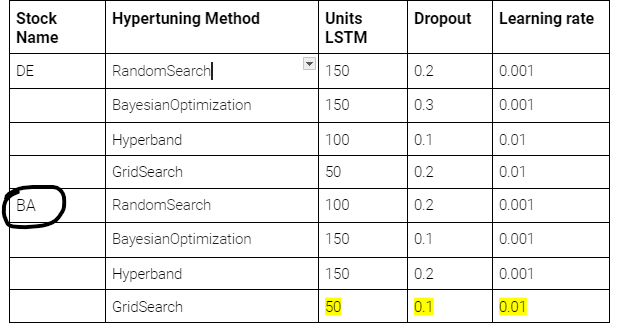

We included a parameter to check for overfitting in the code by monitoring the training and validation losses during the model training process. Overfitting occurs when the model performs well on the training data but poorly on the validation data, indicating that it has learned the training data too well (including noise) and is not generalizing to unseen data.

Steps :

- Split the Training Data: Split the training data into training and validation sets.
- Track Training and Validation Losses: Use these sets to track the training and validation losses during the model fitting.
- Early Stopping (Optional): Not implemented as it is not required and can alter the actual results by stopping early.

## Random Search

In [ ]:
# Include overfitting parameter
# No EARLY STOP


import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

##########################################################################
# Configuration for the LSTM model (Random Search - ******IMPORTANT******)
##########################################################################
config = {'units': 100, 'dropout': 0.2, 'learning_rate': 0.001}



# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)

        return mae, predictions, train_loss, val_loss

# Possible values for epochs and batch size
batch_sizes = [32, 64]
# batch_sizes = [32, 64, 128, 256]
# epochs_list = [20, 40, 50, 75]
epochs_list = [20, 40, 60, 80]






# Varying training periods
training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['MSI']: OperationalError('database is locked')


2/2 [==============================] - 0s 13ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 79.89817773728143
Training Loss: 1.0715302228927612, Validation Loss: 109.54474639892578
2/2 [==============================] - 0s 18ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 66.98471396309989
Training Loss: 1.0015274286270142, Validation Loss: 96.8540267944336
2/2 [==============================] - 0s 18ms/step
Training with 50 years, batch_size 32, epochs 60 - MAE: 62.208534240722656
Training Loss: 0.9687308669090271, Validation Loss: 93.07957458496094
2/2 [==============================] - 0s 17ms/step
Training with 50 years, batch_size 32, epochs 80 - MAE: 63.894925193181116
Training Loss: 0.9574600458145142, Validation Loss: 94.71245574951172


2/2 [==============================] - 0s 16ms/step
Training with 50 years, batch_size 64, epochs 20 - MAE: 94.3357635982453
Training Loss: 1.1722228527069092, Validation Loss: 123.95526885986328


2/2 [==============================] - 0s 16ms/step
Training with 50 years, batch_size 64, epochs 40 - MAE: 76.03362031966921
Training Loss: 1.028404951095581, Validation Loss: 107.89740753173828
2/2 [==============================] - 0s 14ms/step
Training with 50 years, batch_size 64, epochs 60 - MAE: 71.22289796859499
Training Loss: 0.9808511734008789, Validation Loss: 103.65023040771484
2/2 [==============================] - 1s 17ms/step
Training with 50 years, batch_size 64, epochs 80 - MAE: 66.66553824288505
Training Loss: 0.9628663063049316, Validation Loss: 99.81465911865234
2/2 [==============================] - 0s 15ms/step
Training with 40 years, batch_size 32, epochs 20 - MAE: 50.535488552517364
Training Loss: 1.6967655420303345, Validation Loss: 104.52111053466797
2/2 [==============================] - 0s 15ms/step
Training with 40 years, batch_size 32, epochs 40 - MAE: 46.883788093688
Training Loss: 1.6228028535842896, Validation Loss: 100.27164459228516
2/2 [=============

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
##################################
# Define the best configuration
#################################
# IMPORTANT
#################################
# Best Configuration - Years: 10, Batch Size: 32, Epochs: 60 - MAE: 3.2200385199652777


best_years = 10
best_batch_size = 32
best_epochs = 60

##########################################################################
# Configuration for the LSTM model (Random Search - ******IMPORTANT******)
##########################################################################
config = {'units': 100, 'dropout': 0.2, 'learning_rate': 0.001}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        return mae, predictions




# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


## Bayesian Optimization



In [ ]:
# Include overfitting parameter



import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

##########################################################################
# Configuration for the LSTM model (Bayesian  - ******IMPORTANT******)
##########################################################################
config = {'units': 150, 'dropout': 0.1, 'learning_rate': 0.001}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)

        return mae, predictions, train_loss, val_loss



# Possible values for epochs and batch size
batch_sizes = [32, 64]
epochs_list = [20, 40, 60, 80]





# Varying training periods
# Ex- If we are using a 20-year training period, we will use data from 20 years before
# the end date of your training set. The end date of the training data is fixed at 2023-12-31,
# and the start date is calculated by subtracting 20 years from this end date.

training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 30ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 72.69085087851873
Training Loss: 0.7123160362243652, Validation Loss: 102.19564056396484
2/2 [==============================] - 0s 29ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 63.52500249469091
Training Loss: 0.6632856130599976, Validation Loss: 94.6717300415039
2/2 [==============================] - 0s 33ms/step
Training with 50 years, batch_size 32, epochs 60 - MAE: 63.87140982491629
Training Loss: 0.6446781158447266, Validation Loss: 97.92396545410156
2/2 [==============================] - 0s 35ms/step
Training with 50 years, batch_size 32, epochs 80 - MAE: 62.3197274586511
Training Loss: 0.608905553817749, Validation Loss: 93.3561019897461
2/2 [==============================] - 0s 34ms/step
Training with 50 years, batch_size 64, epochs 20 - MAE: 89.2814683460054
Training Loss: 0.7429695129394531, Validation Loss: 119.33419799804688
2/2 [==================

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go


# Best Configuration - Years: 10, Batch Size: 64, Epochs: 80 - MAE: 3.0124608599950395


##################################
# Define the best configuration
#################################
# IMPORTANT
#################################
best_years = 10
best_batch_size = 64
best_epochs = 80

##########################################################################
# Configuration for the LSTM model (Bayesian  - ******IMPORTANT******)
##########################################################################
config = {'units': 150, 'dropout': 0.1, 'learning_rate': 0.001}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        return mae, predictions




# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 33ms/step
MAE on Test Data: 3.115085177951389


## Hyperband

In [ ]:
# Include overfitting parameter
# No EARLY STOP


import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

##########################################################################
# Configuration for the LSTM model (Hyperband  - ******IMPORTANT******)
##########################################################################
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)

        return mae, predictions, train_loss, val_loss



# Possible values for epochs and batch size
batch_sizes = [32, 64]
epochs_list = [20, 40, 60, 80]






# Varying training periods
# Ex- If we are using a 20-year training period, we will use data from 20 years before
# the end date of your training set. The end date of the training data is fixed at 2023-12-31,
# and the start date is calculated by subtracting 20 years from this end date.

training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 31ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 73.42035566057477
Training Loss: 0.9401059150695801, Validation Loss: 105.07255554199219
2/2 [==============================] - 0s 28ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 63.62293291848803
Training Loss: 0.8982372879981995, Validation Loss: 93.39637756347656
2/2 [==============================] - 0s 36ms/step
Training with 50 years, batch_size 32, epochs 60 - MAE: 62.58793058849516
Training Loss: 0.8497372269630432, Validation Loss: 94.72047424316406
2/2 [==============================] - 0s 28ms/step
Training with 50 years, batch_size 32, epochs 80 - MAE: 62.56660861060733
Training Loss: 0.8335740566253662, Validation Loss: 93.5205078125
2/2 [==============================] - 0s 33ms/step
Training with 50 years, batch_size 64, epochs 20 - MAE: 85.26160527789403
Training Loss: 0.9466325044631958, Validation Loss: 117.42871856689453
2/2 [=================

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Best Configuration - Years: 30, Batch Size: 32, Epochs: 60 - MAE: 3.071416219075521


##################################
# Define the best configuration
#################################
# IMPORTANT
#################################
best_years = 30
best_batch_size = 32
best_epochs = 60

##########################################################################
# Configuration for the LSTM model (Hyperband  - ******IMPORTANT******)
##########################################################################
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        return mae, predictions




# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 28ms/step
MAE on Test Data: 4.011740306067089


## Grid Search

In [ ]:
# Include overfitting parameter
# No EARLY STOP


import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

##########################################################################
# Configuration for the LSTM model (GRID Search  - ******IMPORTANT******)
##########################################################################
config = {'units': 50, 'dropout': 0.1, 'learning_rate': 0.01}


# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])

        # Adding EarlyStopping callback to prevent overfitting
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0
        )

        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        predictions = model.predict(X_test)

        mae = mean_absolute_error(y_test, predictions)

        return mae, predictions, train_loss, val_loss



# Possible values for epochs and batch size
batch_sizes = [32, 64]
epochs_list = [20, 40, 60, 80]





# Varying training periods
# Ex- If we are using a 20-year training period, we will use data from 20 years before
# the end date of your training set. The end date of the training data is fixed at 2023-12-31,
# and the start date is calculated by subtracting 20 years from this end date.

training_years = [50, 40, 30, 20, 10]
results = {}

# Test data (2024)
test_start = '2024-01-01'
test_end = '2024-08-10'
df_test = df[test_start:test_end]

# Grid Search for best batch size and epochs
best_config = None
best_mae = float('inf')
best_predictions = None
best_dates = None

for years in training_years:
    train_end = pd.to_datetime('2023-12-31')
    train_start = train_end - pd.DateOffset(years=years)
    df_train = df[train_start:train_end]

    # Split into training and validation sets (80/20 split)
    val_size = int(len(df_train) * 0.2)
    df_val = df_train[-val_size:]
    df_train = df_train[:-val_size]

    window_size = 90
    X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
    X_val, y_val, _, val_dates = preprocess_data(df_val, window_size)
    X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

    for batch_size in batch_sizes:
        for epochs in epochs_list:
            mae, predictions, train_loss, val_loss = train_and_evaluate(
                X_train, y_train, X_val, y_val, X_test, y_test, config, epochs, batch_size)

            if mae < best_mae:
                best_mae = mae
                best_config = {'years': years, 'batch_size': batch_size, 'epochs': epochs}
                best_predictions = predictions
                best_dates = test_dates
            print(f"Training with {years} years, batch_size {batch_size}, epochs {epochs} - MAE: {mae}")
            print(f"Training Loss: {train_loss[-1]}, Validation Loss: {val_loss[-1]}")

print(f"Best Configuration - Years: {best_config['years']}, Batch Size: {best_config['batch_size']}, Epochs: {best_config['epochs']} - MAE: {best_mae}")


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 12ms/step
Training with 50 years, batch_size 32, epochs 20 - MAE: 94.42692311604817
Training Loss: 1.3999145030975342, Validation Loss: 122.9535903930664
2/2 [==============================] - 0s 13ms/step
Training with 50 years, batch_size 32, epochs 40 - MAE: 81.76168375166635
Training Loss: 1.455316185951233, Validation Loss: 109.84291076660156
2/2 [==============================] - 0s 15ms/step
Training with 50 years, batch_size 32, epochs 60 - MAE: 100.26780603802393
Training Loss: 1.9175506830215454, Validation Loss: 128.67108154296875
2/2 [==============================] - 0s 14ms/step
Training with 50 years, batch_size 32, epochs 80 - MAE: 92.1963869125124
Training Loss: 1.7465860843658447, Validation Loss: 120.56332397460938
2/2 [==============================] - 0s 11ms/step
Training with 50 years, batch_size 64, epochs 20 - MAE: 78.41708107600137
Training Loss: 1.09401273727417, Validation Loss: 106.55985260009766
2/2 [==============

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

# Best Configuration - Years: 20, Batch Size: 64, Epochs: 40 - MAE: 3.7216394818018355


##################################
# Define the best configuration
#################################
# IMPORTANT
#################################
best_years = 20
best_batch_size = 64
best_epochs = 40

##########################################################################
# Configuration for the LSTM model (GRID Search  - ******IMPORTANT******)
##########################################################################
config = {'units': 50, 'dropout': 0.1, 'learning_rate': 0.01}

# Download the data
start_date = '1974-01-01'
end_date = '2024-08-10'
all_stocks = ['BA', 'MSI', 'DE', 'SPGI']
df = yf.download(all_stocks, start=start_date, end=end_date)['Adj Close']
df = df.reset_index()

test_start = '2024-01-01'
test_end = '2024-08-10'

# Prepare the BA stock data
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df['BA']

# Preprocess Data
def preprocess_data(df, window_size):
    #scaler = MinMaxScaler(feature_range=(0, 1))
    #scaled_data = scaler.fit_transform(df.values.reshape(-1, 1))

    scaled_data = df.values.reshape(-1, 1)

    X, y, dates = [], [], []
    for i in range(window_size, len(df)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(df.index[i])  # Collect dates for plotting

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshape for LSTM [samples, time steps, features]

    return X, y, None, dates

# Define LSTM Model
def create_lstm_model(units, dropout, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=False, input_shape=(90, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# Train and evaluate each model configuration
def train_and_evaluate(X_train, y_train, X_test, y_test, hyperparams, epochs, batch_size):
        model = create_lstm_model(hyperparams['units'], hyperparams['dropout'], hyperparams['learning_rate'])
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)
        return mae, predictions

# Configuration for the LSTM model
config = {'units': 150, 'dropout': 0.2, 'learning_rate': 0.001}



# Prepare the data using the best configuration
train_end = pd.to_datetime('2023-12-31')
train_start = train_end - pd.DateOffset(years=best_years)
df_train = df[train_start:train_end]
df_test = df[test_start:test_end]

# Prepare data
window_size = 90
X_train, y_train, scaler, train_dates = preprocess_data(df_train, window_size)
X_test, y_test, _, test_dates = preprocess_data(df_test, window_size)

# Train the model using the best configuration
model = create_lstm_model(units=150, dropout=0.2, learning_rate=0.001)
model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=0)

# Make predictions on the test data
predictions = model.predict(X_test)

# Inverse transform the predictions and true values using the scaler
#predictions = scaler.inverse_transform(predictions)
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print(f"MAE on Test Data: {mae}")

# Create a Plotly plot to show the predictions and actual values
fig = go.Figure()

# Plot actual values
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Actual Values', line=dict(color='black', dash='dash')))

# Plot predictions
fig.add_trace(go.Scatter(x=test_dates, y=predictions.flatten(), mode='lines', name=f'Predictions (MAE: {mae:.4f})', line=dict(color='blue')))

# Add layout details
fig.update_layout(
    title="LSTM Model Predictions vs Actual Values",
    xaxis_title="Date",
    yaxis_title="Stock Price",
    legend_title="Legend",
    hovermode="x unified"
)

# Show the plot
fig.show()


[*********************100%%**********************]  4 of 4 completed


2/2 [==============================] - 0s 33ms/step
MAE on Test Data: 3.274235316685268
